In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import cho_solve, solve_triangular, cholesky
from scipy.spatial.distance import cdist

# Data 

In [9]:
# --- Consistent Settings ---
np.random.seed(43) # Seed for reproducibility
N_train = 15       # Number of training points
noise_std_dev = 0.3 # Standard deviation of observation noise sigma_n

# Generate Training Data
X_train = np.random.uniform(-5, 5, N_train)
y_train_true = np.sin(X_train)
y_train = y_train_true + np.random.normal(0, noise_std_dev, N_train)

# Generate Test Data (for prediction and plotting)
X_test = np.linspace(-7, 7, 500)
y_test_true = np.sin(X_test) # True function at test points for comparison

# Reshape inputs to be (N, 1) which is standard for many ML tasks
X_train = X_train[:, np.newaxis]
X_test = X_test[:, np.newaxis]
y_train = y_train[:, np.newaxis] # Ensure y is (N, 1)
N_star = X_test.shape[0] # Number of test points

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")

X_train shape: (15, 1)
y_train shape: (15, 1)
X_test shape: (500, 1)


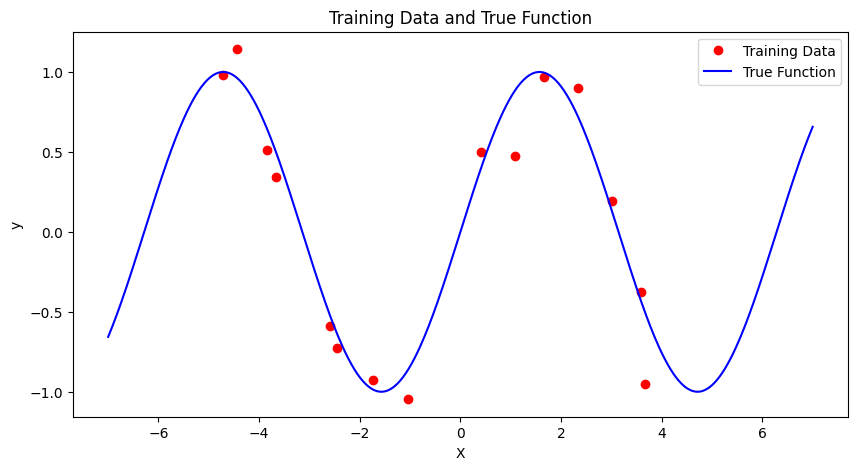

In [10]:
# plot the training data and test data 
plt.figure(figsize=(10, 5))

plt.plot(X_train, y_train, 'ro', label='Training Data')
plt.plot(X_test, y_test_true, 'b-', label='True Function')
plt.title('Training Data and True Function')
plt.xlabel('X')
plt.ylabel('y')
plt.legend()
plt.show()


# 1. Prior 

Before seeing the data, the GP prior defines the type of function we expect to see. This is encoded primarily in the kernel function. The kernel function defines the covariance between two points in the input space. The most common kernel is the squared exponential (or radial basis function) kernel, which is defined as:
```python
def rbf_kernel(x1, x2, length_scale=1.0):
    return np.exp(-0.5 * np.sum((x1 - x2) ** 2) / length_scale ** 2)
```
And mathematically as follows:
$$k(x, x') = \sigma^2 \exp\left(-\frac{(x - x')^2}{2l^2}\right)$$
where $\sigma^2$ is the variance and $l$ is the length scale. The length scale determines how quickly the function can change. A small length scale means the function can change rapidly, while a large length scale means it changes slowly.

The mean function is often assumed to be zero, $m(x) = 0$.



In [49]:
def squared_exponential_kernel(X1, X2, length_scale=1.0, variance=1.0):
    """Computes the squared exponential kernel between two sets of points."""
    l = np.abs(length_scale) + 1e-12 # Avoid division by zero
    
    # compute pairwise squared distance between points in X1 and X2
    # diff[i, j, :] = X1[i, :] - X2[j, :]
    # print shape of X1 
    print("X1 shape before:", X1.shape) # print shape of X1
    print(f"After {X1[:, None, :].shape}") # print shape of X1[:, None, :]
    print(X1[:, None, :].shape) # print shape of X1[:, None, :]
    print("X2 shape before:", X2.shape) # print shape of X2
    print(X2.shape)
    print(f"After {X2[None, :, :].shape}") # print shape of X2[None, :, :]
    # print shape of X2

    diff = X1[:, None, :] - X2[None, :, :]
    
    sqdist = np.sum(diff ** 2, axis=2)
    
    return variance * np.exp(-0.5 * sqdist / l**2)

# --- Hyperparameters (Chosen manually for now) ---
signal_variance_prior = 1.0  # sigma_f^2
lengthscale_prior = 1.0      # l
noise_variance = noise_std_dev**2 # sigma_n^2 (We need this later, define it now)


# example of using the squared_exponential_kernel function

def squared_exponential_kernel_new(X1, X2, length_scale=1.0, variance=1.0):
    """Computes the squared exponential kernel between two sets of points."""
    l = np.abs(length_scale) + 1e-12 # Avoid division by zero
    
    # compute pairwise squared distance between points in X1 and X2
    # diff[i, j, :] = X1[i, :] - X2[j, :]
    # print shape of X1 
    print("X1 shape before:", X1.shape) # print shape of X1
    print(f"After {X1[:, None, :].shape}") # print shape of X1[:, None, :]
    print(X1[:, None, :].shape) # print shape of X1[:, None, :]
    print("X2 shape before:", X2.shape) # print shape of X2
    print(X2.shape)
    print(f"After {X2[None, :, :].shape}") # print shape of X2[None, :, :]
    # print shape of X2

    diff = X1[:, None, :] - X2[None, :, :]
    
    sqdist = np.sum(np.abs(diff), axis=2)
    
    return 1 * (1 +( sqdist / (2 * length_scale**2)))**(-1) + X1 * X2.T


squared_exponential_kernel_lambda = lambda X1, X2, length_scale=1.0, variance=1.0: (
    1 * (1 + (np.sum(np.abs(X1[:, None, :] - X2[None, :, :]), axis=2) / (2 * length_scale**2)))**(-1) + X1 @ X2.T
)

X1 = np.array([[-2.17], [1.99], [0.57], [-3.01], [-1.16], [3.30], [-4.85], [-0.86]])
X2 = np.array([[-1]])

length_scale = 1.0 / np.sqrt(2)  # Length scale for the kernel

K = squared_exponential_kernel_new(X1, X2, length_scale)
print("Squared Exponential Kernel:\n", K)


X1 shape before: (8, 1)
After (8, 1, 1)
(8, 1, 1)
X2 shape before: (1, 1)
(1, 1)
After (1, 1, 1)
Squared Exponential Kernel:
 [[ 2.63082949]
 [-1.73937343]
 [-0.18089494]
 [ 3.34222591]
 [ 2.02206897]
 [-3.11132075]
 [ 5.05618557]
 [ 1.73719298]]


## Illustration: Sampling from the Prior

X1 shape before: (500, 1)
After (500, 1, 1)
(500, 1, 1)
X2 shape before: (500, 1)
(500, 1)
After (1, 500, 1)
K_star_prior shape: (500, 500)
Jitter shape: (500, 500)
Prior mean vector shape: (500,)
Prior samples shape: (20, 500)


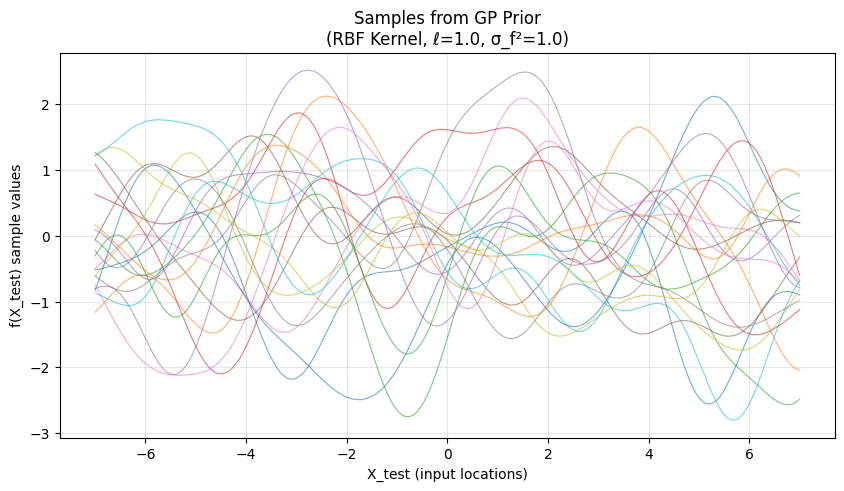

In [16]:
# --- GP Prior Calculations ---

# Assume:
#   X_test               : np.ndarray of shape (N_star, D)
#                          N_star test inputs in D dimensions
#   lengthscale_prior    : float, ℓ (kernel lengthscale)
#   signal_variance_prior: float, σ_f² (kernel signal variance)
#   N_star               : int, number of test points (X_test.shape[0])

# 1) Compute the prior covariance matrix K_** for the test points
#    Equation:
#      (K_**)_{ij} = k(x_{*i}, x_{*j})
#                = σ_f² * exp( -½ * ‖x_{*i} - x_{*j}‖² / ℓ² )
#    Meaning:
#      Covariance between f(x_{*i}) and f(x_{*j}) before observing any data,
#      encoding smoothness and variance assumptions.
K_star_prior = squared_exponential_kernel(
    X_test, X_test,
    lengthscale_prior,
    signal_variance_prior
)  # K_star_prior.shape == (N_star, N_star)
print("K_star_prior shape:", K_star_prior.shape)

# 2) Add jitter for numerical stability
#    Equation:
#      K_stable = K_** + ε I
#    Meaning:
#      Ensures K_stable is strictly positive-definite so that sampling
#      (e.g., via Cholesky in multivariate_normal) doesn’t fail.
jitter_value = 1e-6
jitter = jitter_value * np.eye(N_star)  # shape (N_star, N_star)
print("Jitter shape:", jitter.shape)

# 3) Define the prior mean vector m_*
#    Equation:
#      m_* = [ m(x_{*1}), …, m(x_{*N_star}) ]ᵀ
#    Meaning:
#      Expected function values at test points before data.
#      Common assumption: zero mean prior → m_* = 0 vector.
prior_mean_vector = np.zeros(N_star)  # shape (N_star,)
print("Prior mean vector shape:", prior_mean_vector.shape)

# --- Sampling from the Prior Distribution ---

# Draw samples from the Gaussian Process prior:
#    f_sample ~ 𝒩( m_*, K_stable )
#    Each sample is one possible function realization at X_test.
NUM_PRIOR_SAMPLES = 20
prior_samples = np.random.multivariate_normal(
    mean=prior_mean_vector,           # shape (N_star,)
    cov=K_star_prior + jitter,        # shape (N_star, N_star)
    size=NUM_PRIOR_SAMPLES            # number of independent samples
)
# prior_samples.shape == (NUM_PRIOR_SAMPLES, N_star)
print("Prior samples shape:", prior_samples.shape)

# --- Plotting the Prior Samples ---

plt.figure(figsize=(10, 5))
plt.title(
    f"Samples from GP Prior\n"
    f"(RBF Kernel, ℓ={lengthscale_prior}, σ_f²={signal_variance_prior})"
)
# Transpose prior_samples so that each of the N_star points is on the x-axis
# and each sample (row) becomes a separate line.
plt.plot(X_test, prior_samples.T, lw=0.8, alpha=0.6)
plt.xlabel("X_test (input locations)")
plt.ylabel("f(X_test) sample values")
plt.grid(True, alpha=0.3)
plt.show()

The plot of the prior samples should show a smooth curve with some variation, indicating the uncertainty in the function values at different points. The samples should be centered around zero, as we are sampling from a Gaussian process with zero mean.
- Changing the length scale will affect the smoothness of the function. A smaller length scale will result in more rapid changes, while a larger length scale will produce smoother functions.
- Changing the variance will affect the amplitude of the function. A larger variance will result in larger fluctuations, while a smaller variance will produce smaller fluctuations.


# Part 2: Likelihood and fitting - Incorporating training data

Now we use the training data (X_train, y_train) to fit the GP model, to update our beliefs about the function. This involves the likelihood of observing y_train given the latent functio nvalues f_train = f(X_train). The likelihood is given by: 
$$p(y_{train} | f_{train}) = \mathcal{N}(y_{train} | f_{train}, \sigma^2 I)$$

- **Key computation:**
    - We need the covariance matrix of the noisy training observations, $K_y$, and quantities derived from it for efficient prediction.
    - The covariance matrix $K_y$ is given by:
$$K_y = K(X_{train}, X_{train}) + \sigma^2 I$$
  For efficient computation we do $L = \text{cholesky}(K_y)$ (lower triangular matrix = $L = LL^T$)  \
  $A = K_y^{-1}y_{train} = L^{-1}L^{-T}y_{train}$

In [15]:
import numpy as np
from typing import Tuple

def fit_gpr(
    X_train: np.ndarray,         # shape (N, D): N training points in D dimensions
    y_train: np.ndarray,         # shape (N,):   corresponding targets
    signal_variance: float,      # σ_f²: prior signal variance
    lengthscale: float,          # ℓ:       kernel lengthscale
    noise_variance: float,       # σ_n²: observation noise variance
    jitter: float = 1e-6         # small term for numeric stability
) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """
    Precompute the matrices needed for GPR predictions.

    Kernel:
        K_ij = σ_f² * exp( -||x_i - x_j||² / (2 ℓ²) )
        ⇒ K has shape (N, N)

    Noisy covariance:
        K_y = K + σ_n² I + jitter I
        ⇒ still (N, N)

    Cholesky:
        K_y = L Lᵀ
        ⇒ L is lower-triangular (N, N)

    α-vector:
        α = K_y⁻¹ y
          = (Lᵀ)⁻¹ (L⁻¹ y)
        ⇒ α has shape (N,)

    Returns:
        K_y   (np.ndarray): (N, N) noisy covariance matrix
        K     (np.ndarray): (N, N) noiseless covariance matrix
        L     (np.ndarray): (N, N) lower-triangular Cholesky factor
        alpha (np.ndarray): (N,)   weights for prediction
    """
    N = X_train.shape[0]  # number of training examples

    # 1) Compute the base covariance matrix K (no noise)
    #    Equation: K_ij = σ_f² * exp(-½ * ||x_i - x_j||² / ℓ²)
    K = squared_exponential_kernel(
        X_train, X_train, lengthscale, signal_variance
    )  # K.shape == (N, N)

    # 2) Add observation noise variance and jitter:
    #    K_y = K + σ_n² I_N + jitter * I_N
    #    ensures K_y is positive definite
    K_y = K + noise_variance * np.eye(N) + jitter * np.eye(N)
    # K_y.shape == (N, N)

    # 3) Cholesky factorization: find L such that K_y = L Lᵀ
    #    L is lower-triangular, shape (N, N)
    L = np.linalg.cholesky(K_y)

    # 4) Solve for alpha = K_y⁻¹ y_train
    #    via two triangular solves for efficiency:
    #       (a) w = L⁻¹ y_train
    #       (b) α = (Lᵀ)⁻¹ w
    #    so that α = K_y⁻¹ y_train
    w = np.linalg.solve(L, y_train)       # shape (N,)
    alpha = np.linalg.solve(L.T, w)       # shape (N,)

    return K_y, K, L, alpha


# Example usage:
# X_train: np.ndarray of shape (100, 5)
# y_train: np.ndarray of shape (100,)
# signal_variance = 1.0
# lengthscale = 0.5
# noise_variance = 0.1
K_y, K, L, alpha = fit_gpr(
    X_train, y_train,
    signal_variance=1.0,
    lengthscale=0.5,
    noise_variance=0.1
)
# After this:
# • K      is (100, 100)
# • K_y    is (100, 100)
# • L      is (100, 100) lower-triangular
# • alpha  is (100,)


X1 shape before: (15, 1)
After (15, 1, 1)
(15, 1, 1)
X2 shape before: (15, 1)
(15, 1)
After (1, 15, 1)


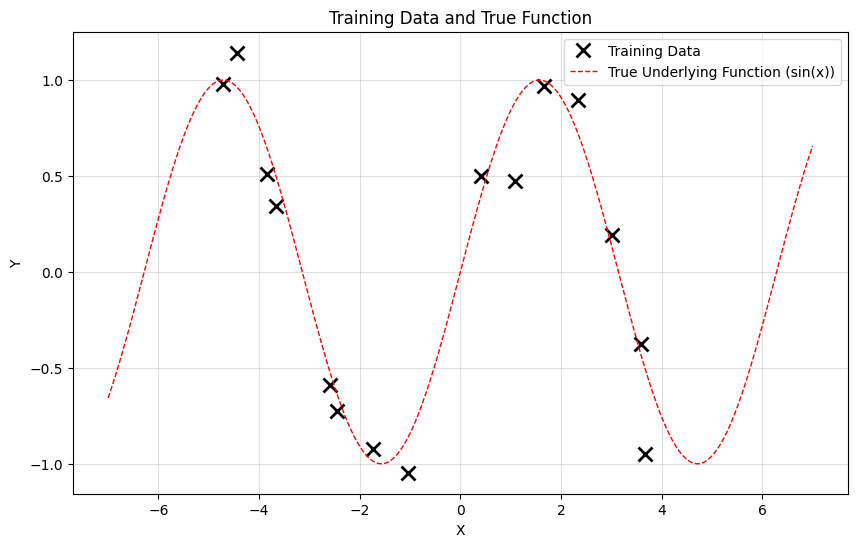

In [14]:
plt.figure(figsize=(10, 6))
plt.plot(X_train, y_train, 'kx', markersize=10, mew=2, label='Training Data')
plt.plot(X_test, y_test_true, 'r--', lw=1, label='True Underlying Function (sin(x))')
plt.title('Training Data and True Function')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.grid(True, alpha=0.4)
plt.show()

In [23]:
import numpy as np

def predict_gpr_numpy(
    X_test: np.ndarray,        # shape (T, D): T test inputs in D dimensions
    X_train: np.ndarray,       # shape (N, D): N training inputs in D dimensions
    L: np.ndarray,             # shape (N, N): lower‐triangular Cholesky factor of K_y
    alpha: np.ndarray,         # shape (N,):      = K_y⁻¹ y_train from fit_gpr
    signal_variance: float,    # σ_f²: prior signal variance
    lengthscale: float         # ℓ:   kernel lengthscale
) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """
    Compute GPR predictive posterior at new inputs X_test.

    Inputs:
      X_test          : (T, D)
      X_train         : (N, D)
      L               : (N, N), from cholesky(K_y)
      alpha           : (N,),  solves K_y^{-1} y_train
      signal_variance : σ_f²
      lengthscale     : ℓ

    Returns:
      f_mean : (T,)
        Posterior mean of latent function f at X_test:
          f_mean = K_* @ α
        where K_* is (T×N) cross‐covariance matrix.

      f_cov  : (T, T)
        Posterior covariance of f:
          cov[f_*] = K_** − Vᵀ V
        where
          K_** is (T×T) prior covariance among X_test,
          V solves L V = K_*ᵀ, so V is (N×T).

      f_std  : (T,)
        Standard deviation of f at each test point:
          f_std[i] = √[f_cov[i,i]]

      y_mean : (T,)
        Posterior mean for noisy observations y:
          y_mean = f_mean

      y_std  : (T,)
        Std dev for noisy y predictions:
          y_std[i] = √[Var(f_*) + σ_n²]
    """
    # Number of test and train points
    T = X_test.shape[0]
    N = X_train.shape[0]

    # 1) Compute cross-covariance K_* (T×N) and test-test covariance K_** (T×T)
    #    Equations:
    #      (K_*)_{i j}   = k(x_{*i}, x_j)   = σ_f² exp( −½ ||x_{*i} − x_j||² / ℓ² )
    #      (K_**)_{i j} = k(x_{*i}, x_{*j})
    K_star      = squared_exponential_kernel(
        X_test, X_train, lengthscale, signal_variance
    )  # shape: (T, N)
    K_star_star = squared_exponential_kernel(
        X_test, X_test, lengthscale, signal_variance
    )  # shape: (T, T)

    # 2) Predictive mean of latent function:
    #    f_mean = K_* @ α      → shape (T,)
    f_mean = K_star.dot(alpha)

    # 3) Predictive covariance of latent function:
    #    Solve L V = K_*ᵀ for V (N×T)
    #    Then cov[f_*] = K_** − Vᵀ V      → shape (T, T)
    V = np.linalg.solve(L, K_star.T)     # shape: (N, T)
    f_cov = K_star_star - V.T.dot(V)     # shape: (T, T)

    # 4) Standard deviation of latent function at each test point:
    #    f_std[i] = sqrt(f_cov[i, i])
    f_std = np.sqrt(np.diag(f_cov))      # shape: (T,)

    # 5) Noisy observation predictions:
    #    y_mean = f_mean                    (T,)
    #    y_std  = sqrt(f_cov_diag + σ_n²)  (T,)
    y_mean = f_mean
    # Note: ensure you have noise_variance in scope if needed here
    #       e.g., passed into function or captured from closure.
    # y_std = np.sqrt(np.diag(f_cov) + noise_variance)

    return f_mean, f_cov


# Example shapes after calling:
# f_mean, f_cov, f_std, y_mean = predict_gpr_numpy(
#     X_test=(T×D), X_train=(N×D),
#     L=(N×N), alpha=(N,),
#     signal_variance=σ_f², lengthscale=ℓ
# )
# → f_mean: (T,)
# → f_cov : (T, T)
# → f_std : (T,)
# → y_mean: (T,)

# Key equations summary:
#   K_*    : (T×N), [k(x_{*i}, x_j)]
#   K_**   : (T×T), [k(x_{*i}, x_{*j})]
#   f_mean = K_* α
#   f_cov  = K_** − (L⁻¹ K_*ᵀ)ᵀ (L⁻¹ K_*ᵀ)
#   f_std[i] = √[f_cov[i,i]]
#   y_std[i] = √[f_cov[i,i] + σ_n²]  (optional)



# Make predictions at test points
f_mean_pred, f_cov_pred = predict_gpr_numpy(
    X_test, X_train, L_fit, alpha_fit,
    signal_variance_prior, lengthscale_prior
)

# Get the standard deviation from the diagonal of the covariance matrix
f_std_pred = np.sqrt(np.diag(f_cov_pred))

# --- Predicting noisy y_* ---
# If we want the uncertainty of predicting a *new noisy observation*, we add noise variance
y_mean_pred = f_mean_pred # Mean is the same
y_std_pred = np.sqrt(np.diag(f_cov_pred) + noise_variance)

print(f"Predicted f_mean shape: {f_mean_pred.shape}")
print(f"Predicted f_cov shape: {f_cov_pred.shape}")
print(f"Predicted f_std shape: {f_std_pred.shape}")

X1 shape before: (500, 1)
After (500, 1, 1)
(500, 1, 1)
X2 shape before: (15, 1)
(15, 1)
After (1, 15, 1)
X1 shape before: (500, 1)
After (500, 1, 1)
(500, 1, 1)
X2 shape before: (500, 1)
(500, 1)
After (1, 500, 1)
Predicted f_mean shape: (500, 1)
Predicted f_cov shape: (500, 500)
Predicted f_std shape: (500,)


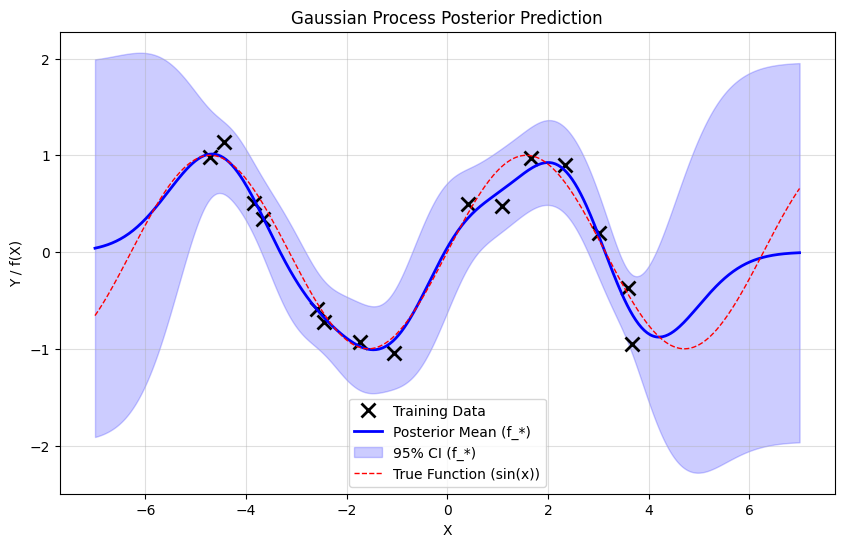

In [24]:
plt.figure(figsize=(10, 6))

# Plot training data
plt.plot(X_train, y_train, 'kx', markersize=10, mew=2, label='Training Data')

# Plot predictive mean for f_*
plt.plot(X_test, f_mean_pred, 'b-', lw=2, label='Posterior Mean (f_*)')

# Plot confidence interval for f_* (95% CI -> approx 1.96 * std dev)
plt.fill_between(X_test.ravel(), # .ravel() ensures it's 1D for fill_between
                 (f_mean_pred - 1.96 * f_std_pred[:, np.newaxis]).ravel(),
                 (f_mean_pred + 1.96 * f_std_pred[:, np.newaxis]).ravel(),
                 color='blue', alpha=0.2, label='95% CI (f_*)')

# Plot true function for comparison
plt.plot(X_test, y_test_true, 'r--', lw=1, label='True Function (sin(x))')

plt.title('Gaussian Process Posterior Prediction')
plt.xlabel('X')
plt.ylabel('Y / f(X)')
plt.legend()
plt.grid(True, alpha=0.4)
#plt.ylim(-2.5, 2.5) # Adjust ylim for better visualization
plt.show()

In [27]:
def sample_posterior_f(f_mean, f_cov, num_samples=1):
    """ Draws samples from the posterior distribution N(f_mean, f_cov) """
    mean_flat = f_mean.ravel()
    N_test = len(mean_flat)
    # Add jitter for numerical stability of Cholesky
    jitter = 1e-6 * np.eye(N_test)
    try:
        L_post = cholesky(f_cov + jitter, lower=True)
    except np.linalg.LinAlgError:
        print("Warning: Cholesky decomposition failed for posterior sampling.")
        # Return mean if sampling fails
        return np.tile(f_mean, (1, num_samples))

    # Sample standard normal variables
    standard_normal_samples = np.random.normal(size=(N_test, num_samples))

    # Transform samples: f_post = mean + L_post @ z
    posterior_samples = mean_flat[:, np.newaxis] + L_post @ standard_normal_samples
    return posterior_samples

# Draw samples from the posterior we calculated
num_posterior_samples = 100
posterior_f_samples = sample_posterior_f(f_mean_pred, f_cov_pred, num_posterior_samples)

print(f"Shape of posterior samples: {posterior_f_samples.shape}") # Should be (N_test, num_posterior_samples)

Shape of posterior samples: (500, 100)


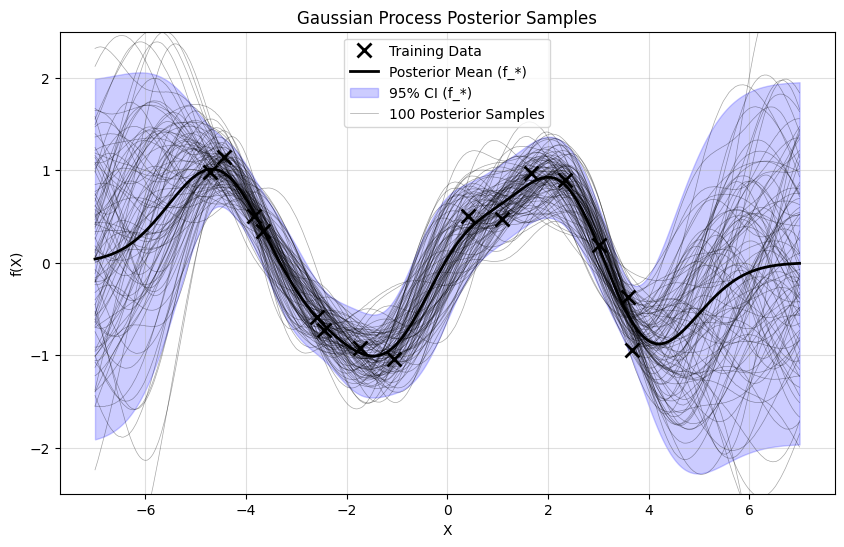

In [33]:
plt.figure(figsize=(10, 6))

# Plot training data
plt.plot(X_train, y_train, 'kx', markersize=10, mew=2, label='Training Data')

# Plot predictive mean for f_*
plt.plot(X_test, f_mean_pred, 'black', lw=2, label='Posterior Mean (f_*)')

# Plot confidence interval for f_*
plt.fill_between(X_test.ravel(),
                 (f_mean_pred - 1.96 * f_std_pred[:, np.newaxis]).ravel(),
                 (f_mean_pred + 1.96 * f_std_pred[:, np.newaxis]).ravel(),
                 color='blue', alpha=0.2, label='95% CI (f_*)')

# Plot the posterior samples
plt.plot(X_test, posterior_f_samples, color='black', lw=0.5, alpha=0.35, label=f'{num_posterior_samples} Posterior Samples')

# Consolidate legend - get unique labels
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())


plt.title('Gaussian Process Posterior Samples')
plt.xlabel('X')
plt.ylabel('f(X)')
plt.grid(True, alpha=0.4)
plt.ylim(-2.5, 2.5) # Adjust ylim
plt.show()

In [34]:
def calculate_log_marginal_likelihood(y_train, alpha, L):
    """ Calculates the log marginal likelihood using pre-computed alpha and L """
    if L is None or alpha is None: # Handle fit failure case
        return -np.inf

    N = y_train.shape[0]
    log_lik = -0.5 * y_train.T @ alpha
    log_lik -= np.sum(np.log(np.diag(L)))
    log_lik -= 0.5 * N * np.log(2 * np.pi)
    return log_lik.item() # Return as scalar

# Calculate likelihood for the hyperparameters we used
log_lik_value = calculate_log_marginal_likelihood(y_train, alpha_fit, L_fit)

print(f"Marginal Log-Likelihood for chosen hyperparameters: {log_lik_value:.3f}")

Marginal Log-Likelihood for chosen hyperparameters: -10.699
